<a href="https://colab.research.google.com/github/JessemanGray/PHYLLOTAXIS/blob/main/Phyllo_Test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as npquery_point
from scipy.spatial import KDTree
import plotly.graph_objects as go
import time
# Generate points on a sphere using the Fibonacci Sphere algorithm
def generate_fibonacci_sphere(n_points, radius=1.0):
    indices = np.arange(n_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices / n_points)  # Latitude
    golden_ratio = (1 + np.sqrt(5)) / 2  # Golden ratio
    theta = 2 * np.pi * indices / golden_ratio  # Longitude

    x = radius * np.cos(theta) * np.sin(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(phi)

    points = np.vstack((x, y, z)).T  # Store in (N, 3) shape
    return points

# Generate grid points
def generate_grid_points(n_points, radius=1.0):
    num_side = int(np.cbrt(n_points))
    x_vals, y_vals, z_vals = np.meshgrid(
        np.linspace(-radius, radius, num_side),
        np.linspace(-radius, radius, num_side),
        np.linspace(-radius, radius, num_side),
    )
    x_vals, y_vals, z_vals = x_vals.flatten(), y_vals.flatten(), z_vals.flatten()
    points = np.vstack((x_vals, y_vals, z_vals)).T
    return points[:n_points]  # Ensure exact number of points

# Generate random points
def generate_random_points(n_points, radius=1.0):
    points = np.random.uniform(-radius, radius, size=(n_points, 3))
    return points

# Benchmark search
def benchmark_search(tree, query_points, k=1):
    search_times = []
    for query_point in query_points:
        start = time.perf_counter()
        _ = tree.query(query_point, k=k)
        end = time.perf_counter()
        search_times.append(end - start)
    return np.mean(search_times), np.std(search_times)

# Visualize with Plotly
def visualize_sphere(points, query_point, nearest_idx, time_vals):
    # Colors: Gradient based on time_vals
    colors = time_vals  # Use time_vals for gradient color

    # Create scatter plot for all points
    scatter = go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors,
            colorscale='Viridis',  # Gradient colormap
            opacity=0.8,
            colorbar=dict(title='Time Value')
        ),
        name='Points'
    )

    # Highlight query point
    query = go.Scatter3d(
        x=[query_point[0]], y=[query_point[1]], z=[query_point[2]],
        mode='markers',
        marker=dict(size=8, color='red'),
        name='Query Point'
    )

    # Highlight nearest neighbor
    neighbor = go.Scatter3d(
        x=[points[nearest_idx, 0]], y=[points[nearest_idx, 1]], z=[points[nearest_idx, 2]],
        mode='markers',
        marker=dict(size=8, color='cyan'),
        name='Nearest Neighbor'
    )

    # Create figure
    fig = go.Figure(data=[scatter, query, neighbor])

    # Update layout for black background
    fig.update_layout(
        scene=dict(
            bgcolor='black',  # Black background
            xaxis=dict(showbackground=False, showticklabels=False, title=''),
            yaxis=dict(showbackground=False, showticklabels=False, title=''),
            zaxis=dict(showbackground=False, showticklabels=False, title='')
        ),
        paper_bgcolor='black',  # Black background outside the plot
        margin=dict(l=0, r=0, b=0, t=0),  # Remove margins
        showlegend=True
    )

    fig.show()

# Main script
if __name__ == "__main__":
    # Parameters
    n_points = 1000
    radius = 1.0
    num_queries = 100

    # Generate datasets
    phyllo_points = generate_fibonacci_sphere(n_points, radius)
    grid_points = generate_grid_points(n_points, radius)
    random_points = generate_random_points(n_points, radius)

    # Create KD-Trees for each dataset
    phyllo_tree = KDTree(phyllo_points)
    grid_tree = KDTree(grid_points)
    random_tree = KDTree(random_points)

    # Generate query points
    query_indices = np.random.choice(n_points, size=num_queries, replace=False)
    query_points = phyllo_points[query_indices]  # Use phyllotactic points for queries

    # Benchmark search for each dataset
    datasets = {
        "Fibonacci Sphere": phyllo_tree,
        "Grid": grid_tree,
        "Random": random_tree,
    }

    results = {}
    for name, tree in datasets.items():
        mean_time, std_time = benchmark_search(tree, query_points)
        results[name] = (mean_time, std_time)
        print(f"{name} Search: {mean_time * 1e6:.2f} µs ± {std_time * 1e6:.2f} µs per query")

    # Perform a single query for visualization
    query_point = query_points[0]  # Use the first query point for visualization
    _, nearest_idx = phyllo_tree.query(query_point, k=1)

    # Time values for gradient color
    time_vals = np.sin(np.linspace(0, 2 * np.pi, n_points))  # Cyclic time values

    # Visualize the sphere
    visualize_sphere(phyllo_points, query_point, nearest_idx, time_vals)

Fibonacci Sphere Search: 40.80 µs ± 17.76 µs per query
Grid Search: 35.67 µs ± 31.45 µs per query
Random Search: 30.55 µs ± 4.01 µs per query


In [ ]:
import numpy as np
import networkx as nx
from scipy.spatial import cKDTree
import heapq

# Generate phyllotactic (Fibonacci) sphere points
def generate_fibonacci_sphere(n_points, radius=1.0):
    indices = np.arange(n_points) + 0.5
    phi = np.arccos(1 - 2 * indices / n_points)  # Latitude
    golden_ratio = (1 + np.sqrt(5)) / 2
    theta = 2 * np.pi * indices / golden_ratio  # Longitude

    x = radius * np.cos(theta) * np.sin(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(phi)

    points = np.vstack((x, y, z)).T
    return points

# Construct a Phyllotactic Point Graph (PPG)
def build_phyllo_graph(points, k=6):
    tree = cKDTree(points)
    graph = nx.Graph()

    for i, point in enumerate(points):
        graph.add_node(i, pos=point)
        distances, neighbors = tree.query(point, k=k+1)  # Include self, discard later
        for j, dist in zip(neighbors[1:], distances[1:]):  # Skip self (first index)
            graph.add_edge(i, j, weight=dist)

    return graph

# A* Search for nearest neighbor
def astar_nn_search(graph, points, query_idx):
    query_point = points[query_idx]
    pq = [(0, query_idx)]  # Priority queue (distance, node)
    visited = set()

    while pq:
        dist, node = heapq.heappop(pq)
        if node in visited:
            continue
        visited.add(node)

        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                heapq.heappush(pq, (graph[node][neighbor]["weight"], neighbor))

    return node  # Nearest neighbor index

# Benchmark PPG search
def benchmark_ppg_search(graph, points, query_indices):
    times = []
    for idx in query_indices:
        start = time.perf_counter()
        _ = astar_nn_search(graph, points, idx)
        end = time.perf_counter()
        times.append(end - start)
    return np.mean(times), np.std(times)

# Main execution
if __name__ == "__main__":
    n_points = 1000
    num_queries = 100

    phyllo_points = generate_fibonacci_sphere(n_points)
    query_indices = np.random.choice(n_points, size=num_queries, replace=False)

    phyllo_graph = build_phyllo_graph(phyllo_points, k=6)

    mean_time, std_time = benchmark_ppg_search(phyllo_graph, phyllo_points, query_indices)
    print(f"PPG Search: {mean_time * 1e6:.2f} µs ± {std_time * 1e6:.2f} µs per query")


PPG Search: 6562.28 µs ± 843.15 µs per query


In [4]:
import plotly.graph_objects as go
import numpy as np

def generate_phyllotactic_sphere():
    """ Generates a filled phyllotactic sphere with inner crystallographic layers """
    φ = (1 + np.sqrt(5)) / 2
    golden_angle = 2 * np.pi * (1 - 1/φ)
    shells = 20
    radii = (np.linspace(0.15, 1, shells)[::-1]) ** (1/3)

    x, y, z = [], [], []

    # Outer shell: 1000 phyllotactic points
    θ = np.arccos(1 - 2 * (np.arange(1000) + 0.5) / 1000)
    φ_outer = golden_angle * np.arange(1000)
    x.extend(np.sin(θ) * np.cos(φ_outer))
    y.extend(np.sin(θ) * np.sin(φ_outer))
    z.extend(np.cos(θ))

    # Inner crystallographic layers
    for i in range(1, shells):
        r = radii[i]
        n = int(1000 * r**2)  # Density scales with square radius
        phase = i * golden_angle / φ**2
        θ_inner = np.arccos(1 - 2 * (np.arange(n) + 0.5) / n)
        φ_inner = phase + golden_angle * np.arange(n)

        x.extend(r * np.sin(θ_inner) * np.cos(φ_inner))
        y.extend(r * np.sin(θ_inner) * np.sin(φ_inner))
        z.extend(r * np.cos(θ_inner))

    return np.array([x, y, z]).T

def generate_grid_sphere(n_points=3000):
    """ Generates a grid-based sphere with matched density """
    grid_size = int(np.cbrt(n_points * 6 / np.pi))  # Approximate cubic lattice
    lin = np.linspace(-1, 1, grid_size)
    x, y, z = np.meshgrid(lin, lin, lin)
    points = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
    points = points[np.linalg.norm(points, axis=1) <= 1]  # Keep only sphere points
    np.random.shuffle(points)
    return points[:n_points]

def generate_random_sphere(n_points=3000):
    """ Generates a stratified random sphere matching phyllotactic density """
    r = np.cbrt(np.random.uniform(0.15**3, 1, n_points))  # Density gradient
    theta = np.arccos(1 - 2 * np.random.uniform(0, 1, n_points))
    phi = np.random.uniform(0, 2 * np.pi, n_points)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x, y, z]).T

def plot_point_cloud(points, title, color_map="OrRd"):
    """ Plots a 3D point cloud with Plotly """
    x, y, z = points.T
    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z, mode='markers',
        marker=dict(size=2, color=np.linalg.norm(points, axis=1),
                    colorscale=color_map, opacity=0.9, line_width=0)
    )])
    fig.update_layout(
        title=title,
        scene=dict(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False, bgcolor='black'),
        margin=dict(l=0, r=0, b=0, t=40),
        paper_bgcolor='black'
    )
    fig.show()

# Generate all three datasets
phyllo_points = generate_phyllotactic_sphere()
grid_points = generate_grid_sphere(len(phyllo_points))
random_points = generate_random_sphere(len(phyllo_points))

# Plot
plot_point_cloud(phyllo_points, "Phyllotactic Sphere")
plot_point_cloud(grid_points, "Grid Sphere")
plot_point_cloud(random_points, "Random Sphere")


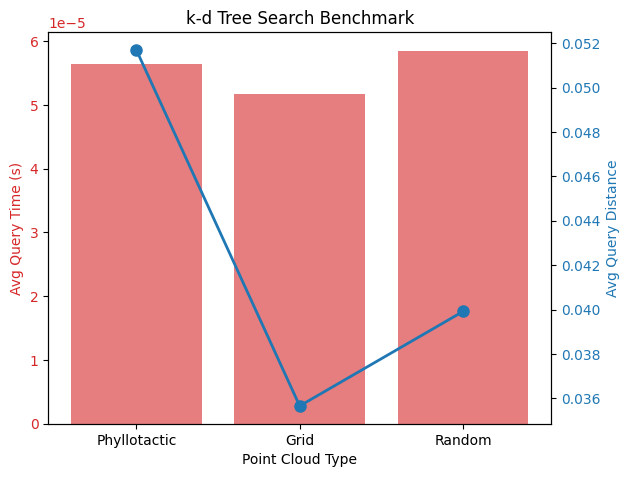

In [5]:
import numpy as np
import time
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

def benchmark_kdtree(point_cloud, query_points):
    """ Measures k-d tree search performance """
    tree = KDTree(point_cloud)

    times = []
    distances = []

    for query in query_points:
        start = time.perf_counter()
        dist, _ = tree.query(query)
        times.append(time.perf_counter() - start)
        distances.append(dist)

    return np.mean(times), np.mean(distances)

# Generate the three datasets
phyllo_points = generate_phyllotactic_sphere()
grid_points = generate_grid_sphere(len(phyllo_points))
random_points = generate_random_sphere(len(phyllo_points))

# Generate query points inside the sphere
num_queries = 100
query_points = generate_random_sphere(num_queries)

# Benchmark k-d tree search
phyllo_time, phyllo_dist = benchmark_kdtree(phyllo_points, query_points)
grid_time, grid_dist = benchmark_kdtree(grid_points, query_points)
random_time, random_dist = benchmark_kdtree(random_points, query_points)

# Plot results
labels = ['Phyllotactic', 'Grid', 'Random']
times = [phyllo_time, grid_time, random_time]
distances = [phyllo_dist, grid_dist, random_dist]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Point Cloud Type')
ax1.set_ylabel('Avg Query Time (s)', color=color)
ax1.bar(labels, times, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Query Distance', color=color)
ax2.plot(labels, distances, color=color, marker='o', markersize=8, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("k-d Tree Search Benchmark")
plt.show()


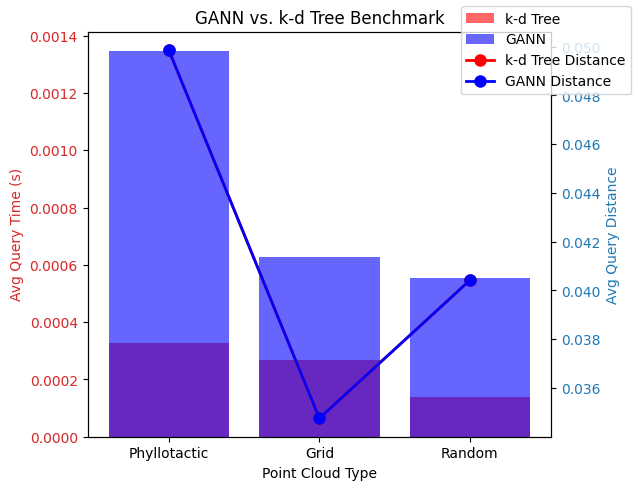

In [10]:
import numpy as np
import time
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def benchmark_gann(point_cloud, query_points, neighbors=1):
    """ Measures Approximate NN search performance using GANN """
    gann = NearestNeighbors(n_neighbors=neighbors, algorithm='ball_tree').fit(point_cloud)

    times = []
    distances = []

    for query in query_points:
        start = time.perf_counter()
        dist, _ = gann.kneighbors([query])
        times.append(time.perf_counter() - start)
        distances.append(dist[0][0])

    return np.mean(times), np.mean(distances)

# Generate point clouds
phyllo_points = generate_phyllotactic_sphere()
grid_points = generate_grid_sphere(len(phyllo_points))
random_points = generate_random_sphere(len(phyllo_points))

# Generate query points
num_queries = 100
query_points = generate_random_sphere(num_queries)

# Benchmark k-d tree search
phyllo_kd_time, phyllo_kd_dist = benchmark_kdtree(phyllo_points, query_points)
grid_kd_time, grid_kd_dist = benchmark_kdtree(grid_points, query_points)
random_kd_time, random_kd_dist = benchmark_kdtree(random_points, query_points)

# Benchmark GANN search
phyllo_gann_time, phyllo_gann_dist = benchmark_gann(phyllo_points, query_points)
grid_gann_time, grid_gann_dist = benchmark_gann(grid_points, query_points)
random_gann_time, random_gann_dist = benchmark_gann(random_points, query_points)

# Compare Results
labels = ['Phyllotactic', 'Grid', 'Random']
kd_times = [phyllo_kd_time, grid_kd_time, random_kd_time]
gann_times = [phyllo_gann_time, grid_gann_time, random_gann_time]

kd_dists = [phyllo_kd_dist, grid_kd_dist, random_kd_dist]
gann_dists = [phyllo_gann_dist, grid_gann_dist, random_gann_dist]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Point Cloud Type')
ax1.set_ylabel('Avg Query Time (s)', color=color)
ax1.bar(labels, kd_times, color='red', alpha=0.6, label="k-d Tree")
ax1.bar(labels, gann_times, color='blue', alpha=0.6, label="GANN")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Query Distance', color=color)
ax2.plot(labels, kd_dists, color='red', marker='o', markersize=8, linewidth=2, label="k-d Tree Distance")
ax2.plot(labels, gann_dists, color='blue', marker='o', markersize=8, linewidth=2, label="GANN Distance")
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper right')
fig.tight_layout()
plt.title("GANN vs. k-d Tree Benchmark")
plt.show()


In [13]:
pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553316 sha256=66eb105785853bb93cae88f81388934d1f413e328a9a2483216d8252b7daaa3b
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


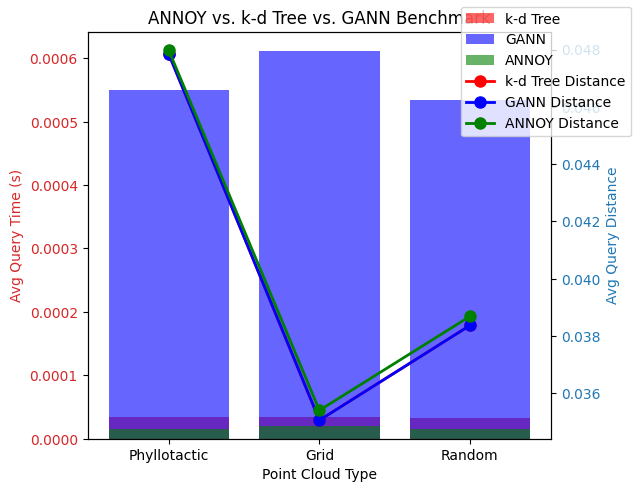

In [16]:
import numpy as np
import time
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors
import annoy  # ANNOY

def benchmark_annoy(point_cloud, query_points, neighbors=1, n_trees=10):
    """ Measures Approximate NN search performance using ANNOY """
    dim = len(point_cloud[0])
    annoy_index = annoy.AnnoyIndex(dim, 'euclidean')

    # Build ANNOY index
    for i, p in enumerate(point_cloud):
        annoy_index.add_item(i, p)
    annoy_index.build(n_trees)  # More trees = better accuracy

    times = []
    distances = []

    for query in query_points:
        start = time.perf_counter()
        idx = annoy_index.get_nns_by_vector(query, neighbors, include_distances=True)
        times.append(time.perf_counter() - start)
        distances.append(idx[1][0])  # Get first neighbor's distance

    return np.mean(times), np.mean(distances)

# Generate point clouds
phyllo_points = generate_phyllotactic_sphere()
grid_points = generate_grid_sphere(len(phyllo_points))
random_points = generate_random_sphere(len(phyllo_points))

# Generate query points
num_queries = 100
query_points = generate_random_sphere(num_queries)

# Benchmark ANNOY
phyllo_annoy_time, phyllo_annoy_dist = benchmark_annoy(phyllo_points, query_points)
grid_annoy_time, grid_annoy_dist = benchmark_annoy(grid_points, query_points)
random_annoy_time, random_annoy_dist = benchmark_annoy(random_points, query_points)

# Compare with k-d Tree & GANN
phyllo_kd_time, phyllo_kd_dist = benchmark_kdtree(phyllo_points, query_points)
grid_kd_time, grid_kd_dist = benchmark_kdtree(grid_points, query_points)
random_kd_time, random_kd_dist = benchmark_kdtree(random_points, query_points)

phyllo_gann_time, phyllo_gann_dist = benchmark_gann(phyllo_points, query_points)
grid_gann_time, grid_gann_dist = benchmark_gann(grid_points, query_points)
random_gann_time, random_gann_dist = benchmark_gann(random_points, query_points)

# Visualization
labels = ['Phyllotactic', 'Grid', 'Random']
annoy_times = [phyllo_annoy_time, grid_annoy_time, random_annoy_time]
kd_times = [phyllo_kd_time, grid_kd_time, random_kd_time]
gann_times = [phyllo_gann_time, grid_gann_time, random_gann_time]

annoy_dists = [phyllo_annoy_dist, grid_annoy_dist, random_annoy_dist]
kd_dists = [phyllo_kd_dist, grid_kd_dist, random_kd_dist]
gann_dists = [phyllo_gann_dist, grid_gann_dist, random_gann_dist]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Point Cloud Type')
ax1.set_ylabel('Avg Query Time (s)', color=color)
ax1.bar(labels, kd_times, color='red', alpha=0.6, label="k-d Tree")
ax1.bar(labels, gann_times, color='blue', alpha=0.6, label="GANN")
ax1.bar(labels, annoy_times, color='green', alpha=0.6, label="ANNOY")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Query Distance', color=color)
ax2.plot(labels, kd_dists, color='red', marker='o', markersize=8, linewidth=2, label="k-d Tree Distance")
ax2.plot(labels, gann_dists, color='blue', marker='o', markersize=8, linewidth=2, label="GANN Distance")
ax2.plot(labels, annoy_dists, color='green', marker='o', markersize=8, linewidth=2, label="ANNOY Distance")
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper right')
fig.tight_layout()
plt.title("ANNOY vs. k-d Tree vs. GANN Benchmark")
plt.show()


In [19]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 56.6 MB/s eta 0:00:00


In [20]:
import numpy as np
import faiss
import annoy
import time
import random

# Generate points on a phyllotactic shell (with larger dataset and shells)
def generate_phyllotactic_sphere(n_points, shells=50, radius=1.0):
    φ = (1 + np.sqrt(5)) / 2
    golden_angle = 2 * np.pi * (1 - 1/φ)
    radii = np.linspace(0.15, 1, shells)[::-1]  # Inverse to get denser outer shells
    x, y, z = [], [], []

    # Outer phyllotactic shell
    for i in range(n_points):
        theta = np.arccos(1 - 2 * (i + 0.5) / n_points)
        φ_outer = golden_angle * i
        x.append(np.sin(theta) * np.cos(φ_outer))
        y.append(np.sin(theta) * np.sin(φ_outer))
        z.append(np.cos(theta))

    # Crystallographic inner shells
    for r in radii:
        num_points = int(1000 * r**2)
        phase = random.random() * golden_angle
        for i in range(num_points):
            theta = np.arccos(1 - 2 * (i + 0.5) / num_points)
            φ_inner = phase + golden_angle * i
            x.append(r * np.sin(theta) * np.cos(φ_inner))
            y.append(r * np.sin(theta) * np.sin(φ_inner))
            z.append(r * np.cos(theta))

    return np.array([x, y, z]).T

# Benchmark FAISS Search
def benchmark_faiss_search(index, query_points, k=1):
    search_times = []
    for query_point in query_points:
        start = time.perf_counter()
        D, I = index.search(np.array([query_point]), k)
        end = time.perf_counter()
        search_times.append(end - start)
    return np.mean(search_times), np.std(search_times)

# Benchmark ANNOY Search
def benchmark_annoy_search(index, query_points, k=1):
    search_times = []
    for query_point in query_points:
        start = time.perf_counter()
        indices, distances = index.get_nns_by_vector(query_point, k, include_distances=True)
        end = time.perf_counter()
        search_times.append(end - start)
    return np.mean(search_times), np.std(search_times)

# Main
if __name__ == "__main__":
    n_points = 10000  # Larger number of points
    shells = 50  # More shells for complexity
    radius = 1.0
    num_queries = 10

    # Generate phyllotactic points
    points = generate_phyllotactic_sphere(n_points, shells=shells, radius=radius)

    # FAISS indexing and search
    points_faiss = np.array(points, dtype=np.float32)
    faiss_index = faiss.IndexFlatL2(3)
    faiss_index.add(points_faiss)

    # ANNOY indexing and search
    annoy_index = annoy.AnnoyIndex(3, 'euclidean')
    for i in range(n_points):
        annoy_index.add_item(i, points[i])
    annoy_index.build(10)  # 10 trees

    # Generate query points
    query_indices = np.random.choice(n_points, size=num_queries, replace=False)
    query_points = points[query_indices]

    # FAISS Benchmark
    mean_time_faiss, std_time_faiss = benchmark_faiss_search(faiss_index, query_points)
    print(f"FAISS Search: {mean_time_faiss * 1e6:.2f} µs ± {std_time_faiss * 1e6:.2f} µs per query")

    # ANNOY Benchmark
    mean_time_annoy, std_time_annoy = benchmark_annoy_search(annoy_index, query_points)
    print(f"ANNOY Search: {mean_time_annoy * 1e6:.2f} µs ± {std_time_annoy * 1e6:.2f} µs per query")


FAISS Search: 292.78 µs ± 42.18 µs per query
ANNOY Search: 26.74 µs ± 8.19 µs per query


In [21]:
import numpy as np
import annoy
import time
from scipy.spatial import KDTree
import plotly.graph_objects as go

# Generate phyllotactic points for a single shell
def generate_phyllo_sphere(n_points, radius=1.0):
    φ = (1 + np.sqrt(5))/2
    golden_angle = 2 * np.pi * (1 - 1/φ)

    θ = np.arccos(1 - 2*(np.arange(n_points)+0.5)/n_points)  # Latitude
    φ_outer = golden_angle * np.arange(n_points)  # Longitude
    x = radius * np.sin(θ) * np.cos(φ_outer)
    y = radius * np.sin(θ) * np.sin(φ_outer)
    z = radius * np.cos(θ)

    points = np.vstack((x, y, z)).T
    return points

# Generate grid points
def generate_grid_points(n_points, radius=1.0):
    num_side = int(np.cbrt(n_points))
    x_vals, y_vals, z_vals = np.meshgrid(
        np.linspace(-radius, radius, num_side),
        np.linspace(-radius, radius, num_side),
        np.linspace(-radius, radius, num_side),
    )
    x_vals, y_vals, z_vals = x_vals.flatten(), y_vals.flatten(), z_vals.flatten()
    points = np.vstack((x_vals, y_vals, z_vals)).T
    return points[:n_points]

# Generate random points
def generate_random_points(n_points, radius=1.0):
    points = np.random.uniform(-radius, radius, size=(n_points, 3))
    return points

# Benchmark search
def benchmark_search(tree, query_points, k=1):
    search_times = []
    for query_point in query_points:
        start = time.perf_counter()
        _ = tree.query(query_point, k=k)
        end = time.perf_counter()
        search_times.append(end - start)
    return np.mean(search_times), np.std(search_times)

# Benchmark ANNOY search
def benchmark_annoy_search(annoy_index, query_points, k=1):
    search_times = []
    for query_point in query_points:
        start = time.perf_counter()
        annoy_index.get_nns_by_vector(query_point.tolist(), k)
        end = time.perf_counter()
        search_times.append(end - start)
    return np.mean(search_times), np.std(search_times)

# Main script
if __name__ == "__main__":
    n_points = 10000
    radius = 1.0
    num_queries = 100

    # Generate phyllotactic points, grid, and random points
    phyllo_points = generate_phyllo_sphere(n_points, radius)
    grid_points = generate_grid_points(n_points, radius)
    random_points = generate_random_points(n_points, radius)

    # Create KD-Trees for grid and random points
    grid_tree = KDTree(grid_points)
    random_tree = KDTree(random_points)

    # Create ANNOY index for phyllotactic points
    annoy_index = annoy.AnnoyIndex(3, 'angular')
    for i, point in enumerate(phyllo_points):
        annoy_index.add_item(i, point.tolist())
    annoy_index.build(10)  # Number of trees

    # Generate query points
    query_indices = np.random.choice(n_points, size=num_queries, replace=False)
    query_points = phyllo_points[query_indices]  # Use phyllotactic points for queries

    # Benchmark search for each method
    datasets = {
        "Phyllo (ANNOY)": annoy_index,
        "Grid (KDTree)": grid_tree,
        "Random (KDTree)": random_tree,
    }

    results = {}
    for name, tree in datasets.items():
        if 'ANNOY' in name:
            mean_time, std_time = benchmark_annoy_search(tree, query_points)
        else:
            mean_time, std_time = benchmark_search(tree, query_points)
        results[name] = (mean_time, std_time)
        print(f"{name} Search: {mean_time * 1e6:.2f} µs ± {std_time * 1e6:.2f} µs per query")

    # Optionally: Visualize the sphere
    fig = go.Figure(data=[go.Scatter3d(
        x=phyllo_points[:, 0], y=phyllo_points[:, 1], z=phyllo_points[:, 2], mode='markers',
        marker=dict(size=2.5, color=np.linalg.norm(phyllo_points, axis=1), colorscale='OrRd', opacity=0.9)
    )])
    fig.update_layout(
        scene=dict(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False, bgcolor='black'),
        margin=dict(l=0,r=0,b=0,t=0),
        paper_bgcolor='black'
    )
    fig.show()


Phyllo (ANNOY) Search: 36.37 µs ± 155.74 µs per query
Grid (KDTree) Search: 58.88 µs ± 22.29 µs per query
Random (KDTree) Search: 54.02 µs ± 9.12 µs per query


In [22]:
import numpy as np
import annoy
import time
from scipy.spatial import KDTree
import plotly.graph_objects as go

# Generate phyllotactic points for a single shell
def generate_phyllo_sphere(n_points, radius=1.0):
    φ = (1 + np.sqrt(5))/2
    golden_angle = 2 * np.pi * (1 - 1/φ)

    θ = np.arccos(1 - 2*(np.arange(n_points)+0.5)/n_points)  # Latitude
    φ_outer = golden_angle * np.arange(n_points)  # Longitude
    x = radius * np.sin(θ) * np.cos(φ_outer)
    y = radius * np.sin(θ) * np.sin(φ_outer)
    z = radius * np.cos(θ)

    points = np.vstack((x, y, z)).T
    return points

# Generate grid points
def generate_grid_points(n_points, radius=1.0):
    num_side = int(np.cbrt(n_points))
    x_vals, y_vals, z_vals = np.meshgrid(
        np.linspace(-radius, radius, num_side),
        np.linspace(-radius, radius, num_side),
        np.linspace(-radius, radius, num_side),
    )
    x_vals, y_vals, z_vals = x_vals.flatten(), y_vals.flatten(), z_vals.flatten()
    points = np.vstack((x_vals, y_vals, z_vals)).T
    return points[:n_points]

# Generate random points
def generate_random_points(n_points, radius=1.0):
    points = np.random.uniform(-radius, radius, size=(n_points, 3))
    return points

# Benchmark search
def benchmark_annoy_search(annoy_index, query_points, k=1):
    search_times = []
    for query_point in query_points:
        start = time.perf_counter()
        annoy_index.get_nns_by_vector(query_point.tolist(), k)
        end = time.perf_counter()
        search_times.append(end - start)
    return np.mean(search_times), np.std(search_times)

# Main script
if __name__ == "__main__":
    n_points = 10000
    radius = 1.0
    num_queries = 100

    # Generate phyllotactic points, grid, and random points
    phyllo_points = generate_phyllo_sphere(n_points, radius)
    grid_points = generate_grid_points(n_points, radius)
    random_points = generate_random_points(n_points, radius)

    # Create ANNOY index for phyllotactic points
    phyllo_index = annoy.AnnoyIndex(3, 'angular')
    for i, point in enumerate(phyllo_points):
        phyllo_index.add_item(i, point.tolist())
    phyllo_index.build(10)  # Number of trees

    # Create ANNOY index for grid points
    grid_index = annoy.AnnoyIndex(3, 'angular')
    for i, point in enumerate(grid_points):
        grid_index.add_item(i, point.tolist())
    grid_index.build(10)

    # Create ANNOY index for random points
    random_index = annoy.AnnoyIndex(3, 'angular')
    for i, point in enumerate(random_points):
        random_index.add_item(i, point.tolist())
    random_index.build(10)

    # Generate query points
    query_indices = np.random.choice(n_points, size=num_queries, replace=False)
    query_points = phyllo_points[query_indices]  # Use phyllotactic points for queries

    # Benchmark search for each method
    datasets = {
        "Phyllo (ANNOY)": phyllo_index,
        "Grid (ANNOY)": grid_index,
        "Random (ANNOY)": random_index,
    }

    results = {}
    for name, annoy_index in datasets.items():
        mean_time, std_time = benchmark_annoy_search(annoy_index, query_points)
        results[name] = (mean_time, std_time)
        print(f"{name} Search: {mean_time * 1e6:.2f} µs ± {std_time * 1e6:.2f} µs per query")

    # Optionally: Visualize the sphere
    fig = go.Figure(data=[go.Scatter3d(
        x=phyllo_points[:, 0], y=phyllo_points[:, 1], z=phyllo_points[:, 2], mode='markers',
        marker=dict(size=2.5, color=np.linalg.norm(phyllo_points, axis=1), colorscale='OrRd', opacity=0.9)
    )])
    fig.update_layout(
        scene=dict(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False, bgcolor='black'),
        margin=dict(l=0,r=0,b=0,t=0),
        paper_bgcolor='black'
    )
    fig.show()


Phyllo (ANNOY) Search: 15.10 µs ± 5.04 µs per query
Grid (ANNOY) Search: 17.18 µs ± 24.44 µs per query
Random (ANNOY) Search: 14.84 µs ± 3.21 µs per query
